In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import catboost
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [1]:
import re
import sys
import pandas as pd
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from catboost import CatBoostRegressor
import numpy as np
from fastapi.responses import JSONResponse

sys.path.append('../')
from pipelines.scraper import scrape_car_data
from pipelines.preprocess_pipeline import *
from pipelines.database_helpers import read_sql_query, setup_database

In [2]:
from price_prediction_api.prediction_api import prediction_process

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
engine = setup_database()


In [4]:
# Load the model
model = CatBoostRegressor()
model.load_model('../models/car_price_predictor.cbm')

In [5]:
url = 'https://www.hasznaltauto.hu/szemelyauto/volkswagen/tiguan/volkswagen_tiguan_2.0_tdi_bmt_scr_highline_4motion_dsg_113ekm-19886977'
data = scrape_car_data(url)

In [6]:
data

0       vételár vételár eur évjárat állapot                       kivitel  \
1  9 399 000 Ft    € 23 912  2021/2  Normál  Városi terepjáró (crossover)   

0     finanszírozás km. óra állás szállítható szem. száma ajtók száma   szín  \
1  25%-tól elvihető    113 291 km                    5 fő           5  Fehér   

0  ...                                     content_info_1  \
1  ...  \n        Das WeltAuto. Nagykanizsa, Kaposvári...   

0                                     content_info_2  \
1  \n        (+36) 30/XXXXXXXTelefonszám megjelen...   

0                                     content_info_3  \
1  \n        (+36) 20/XXXXXXXTelefonszám megjelen...   

0                                     content_info_4  \
1  \n        xxxxxxxxxxx@xxxxxxxxxxxxxxxxxxxx.xxE...   

0                           content_info_5                    content_info_6  \
1  \n        http://www.istivanauto.hu      \n        Hirdetéskód: 19886977    

0                                       feature_list  \
1  [műszaki, kulcsnélküli nyitórendszer, kulcsnél...   

0                                        description  \
1  \nLeírás\nDas WeltAuto. Nagykanizsa -- 1.Tulaj...   

0                                               link     chassis_number  
1  https://www.hasznaltauto.hu/szemelyauto/volksw...  WVGZZZ5NZLW410006  

[1 rows x 35 columns]

In [14]:
mkdir shap-images

In [15]:
prediction_process(url)

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['stb', 'оda'] not in stop_words.


(13010000,
 9399000,
 'shap_waterfall_volkswagen_tiguan_2.0_tdi_bmt_scr_highline_4motion_dsg_113ekm-19886977.png')

In [7]:
from sqlalchemy import MetaData, Table


In [8]:
# Use SQLAlchemy to reflect the table structure
metadata = MetaData()
table = Table('engineered_car_data', metadata,autoload_with=engine )


In [9]:
df_processed = data_processing(data, for_prediction=True, )

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['stb', 'оda'] not in stop_words.


In [12]:
 df_processed.select_dtypes(include=['bool']).columns

Index(['buy_from_shop', 'keyless entry system', 'heatable mirror',
       'electric mirror', 'electric rear window', 'electric window in front',
       'led headlight', 'rain sensor', 'running light',
       'electrically folding exterior mirrors', 'electric tailgate movement',
       'sports seats', 'steering gear', 'board computer',
       'predictable government', 'knee airbag', 'esp (speed stabilizer)',
       'cd car radio', 'VAT can be reclaimed', 'guided service book',
       'herdbook', 'regularly maintained', 'from the first owner',
       'first placing on the market in Hungary', 'car offsetting is possible',
       'memory card reader', 'apple carplay', 'android auto', 'touch screen',
       'play mp3', 'USB connector', 'bluetooth speakerphone',
       'abs (anti-lock braking)', 'passenger airbag', 'side airbag',
       'eds (electronic differential lock)', 'parking assistant',
       'distance control cruise control', 'brake assistant', 'immobiliser',
       'tire pressure 

In [11]:
df_processed['buy_from_shop']

0    True
Name: buy_from_shop, dtype: bool

In [35]:
# Load data
query = """
    SELECT *
    FROM engineered_car_data
"""

df = read_sql_query(engine, query)
categorical_features = list(df.select_dtypes(include=["object"]).columns)
non_categorical_features = list(df.select_dtypes(exclude=["object"]).columns)
df[non_categorical_features] = df[non_categorical_features].astype(float)

target = 'price (HUF)'
target_log = 'price log'
df[target_log] = np.log10(df[target])

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [36]:
# Handle missing values
for col in model.feature_names_:
    if col in categorical_features:
        df[col] = df[col].fillna('missing')
    else:
        df[col] = df[col].fillna(np.nan)

In [37]:
df_original = df[df.link == url]

In [38]:
df_original

price (HUF) condition                        design  financing  \
89974    9399000.0    Normál  Városi terepjáró (crossover)       25.0   

       clock position (km)  shippable persons number  number of doors  color  \
89974             113291.0                       5.0              5.0  fehér   

       own weight (kg)  total weight (kg)  ...  tfidf_please tfidf_view  \
89974           1755.0             2290.0  ...      0.194127        0.0   

      tfidf_technical  tfidf_system  tfidf_service tfidf_owner tfidf_leads  \
89974             0.0           0.0            0.0         0.0         0.0   

       tfidf_condition  tfidf_seat price log  
89974              0.0    0.184689  6.973082  

[1 rows x 240 columns]

In [65]:
df_processed["kept in garage"]

0    0.0
Name: kept in garage, dtype: float64

In [64]:
for col in model.feature_names_:
    if col in df_processed.columns:
        if df_original[col].values[0] != df_processed[col].values[0]:
            print(col)
            print(df_original[col])
            print(df_processed[col])
            print()

city
89974    vác
Name: city, dtype: object
0    nagykanizsa
Name: city, dtype: object

speaker count
89974   NaN
Name: speaker count, dtype: float64
0   NaN
Name: speaker count, dtype: float64



In [ ]:
df[""]

In [20]:
col = 'speaker count'

In [23]:
type(df_original[col].values[0])


numpy.float64

In [24]:
type(df_processed[col].values[0])

numpy.float64

In [61]:
df_processed['type of climate'].values[0] is None

True

In [62]:
# Check for missing columns and add them with appropriate default values
cat_features_indices = model.get_cat_feature_indices()
for idx, col in enumerate(model.feature_names_):
    if (col not in df_processed.columns) or (df_processed[col].values[0] is None):
        # Fill missing categorical features with 'missing' and numerical features with np.nan
        if idx in cat_features_indices:
            df_processed[col] = 'missing'
            if col == 'type of climate':
                print(df_processed[col])
        else:
            df_processed[col] = np.nan

for col in bool_columns:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].fillna(0.0)
            

0    missing
Name: type of climate, dtype: object


In [66]:

# Make prediction
prediction = model.predict(df_processed[model.feature_names_])[0]
int(round(10 ** prediction / 1000) * 1000)

13010000

In [28]:
# Make prediction
prediction = model.predict(df_processed[model.feature_names_])[0]
int(round(10 ** prediction / 1000) * 1000)

12609000

In [27]:
df_processed['city'] = 'vác'

In [49]:
# Check for missing columns and add them with appropriate default values
cat_features_indices = model.get_cat_feature_indices()
for idx, col in enumerate(model.feature_names_):
    if (col not in df_original.columns) or (df_original[col].values[0] is None):
        # Fill missing categorical features with 'missing' and numerical features with np.nan
        if idx in cat_features_indices:
            df_original[col] = 'missing'
        else:
            df_original[col] = np.nan

# Make prediction
prediction2 = model.predict(df_processed[model.feature_names_])[0]
int(round(10 ** prediction2 / 1000) * 1000)

12635000

In [38]:
int(round(10 ** prediction / 1000) * 1000)

12635000

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['stb', 'оda'] not in stop_words.


FileNotFoundError: [Errno 2] No such file or directory: 'shap-images/shap_waterfall_volkswagen_tiguan_2.0_tdi_bmt_scr_highline_4motion_dsg_113ekm-19886977.png'

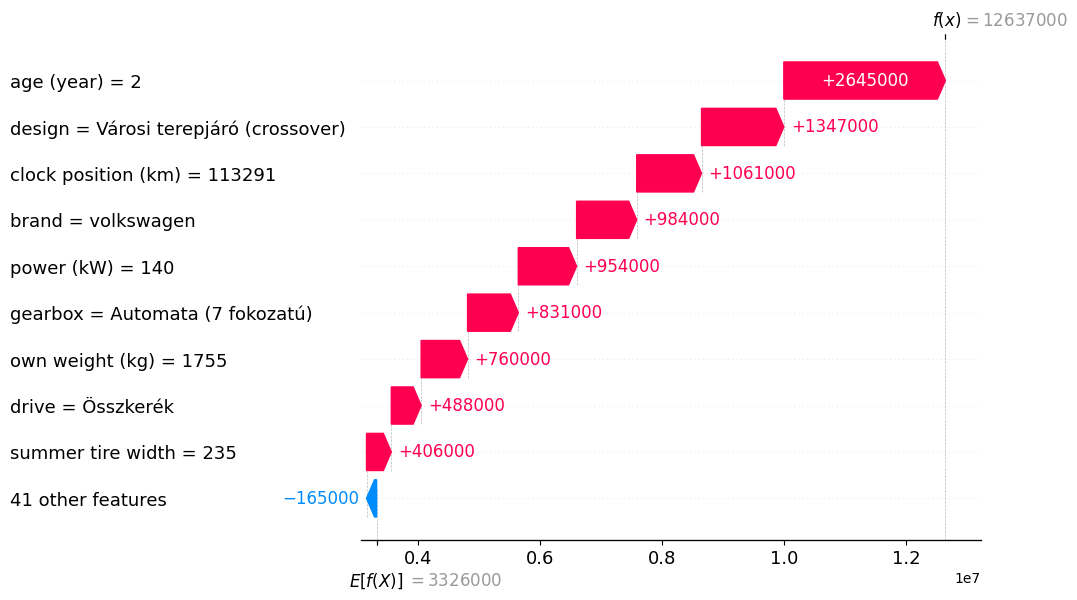

In [40]:
prediction_process(url)

In [165]:
import face_recognition


In [166]:
face_recognition.__version__

'1.2.3'

In [2]:
sys.path.append('../')

In [3]:
from pipelines.model_creation import *

In [4]:
"""
Main workflow for training the model.
"""
engine = setup_database()

# Load data
query = """
    SELECT *
    FROM engineered_car_data
"""
logging.info('Load data')

df = read_sql_query(engine, query)
df.set_index('link', inplace=True)
categorical_features = list(df.select_dtypes(include=["object"]).columns)
non_categorical_features = list(df.select_dtypes(exclude=["object"]).columns)
df[non_categorical_features] = df[non_categorical_features].astype(float)

target = 'price (HUF)'
target_log = 'price log'
df[target_log] = np.log10(df[target])

logging.info('Handle high cardinality features')
# Handle categorical values that are less frequent
for col in categorical_features:
    print(col)
    if col == 'city':
        df[col] = replace_less_frequent(df[col], 500, 10)
    else:
        df[col] = replace_less_frequent(df[col], 1000, 10)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


condition
design
color
type of climate
fuel
drive
gearbox
brand
metallic_polish
city


In [5]:
# Load the model
model = CatBoostRegressor()
model.load_model('../models/car_price_predictor.cbm')

In [6]:
# Assuming 'model' is your trained CatBoost model
cat_features_indices = model.get_cat_feature_indices()
categorical_features = [model.feature_names_[x] for x in cat_features_indices]

In [7]:
for  col in model.feature_names_:
    if col in categorical_features:
        df[col] = df[col].fillna('missing')
    else:
        df[col] = df[col].fillna(np.nan)

In [8]:
# Initialize explainer (do this only once after loading the model)
explainer = shap.Explainer(model)

In [153]:
msk = (df.index == 'https://www.hasznaltauto.hu/szemelyauto/hyundai/genesis/hyundai_genesis-19727104')

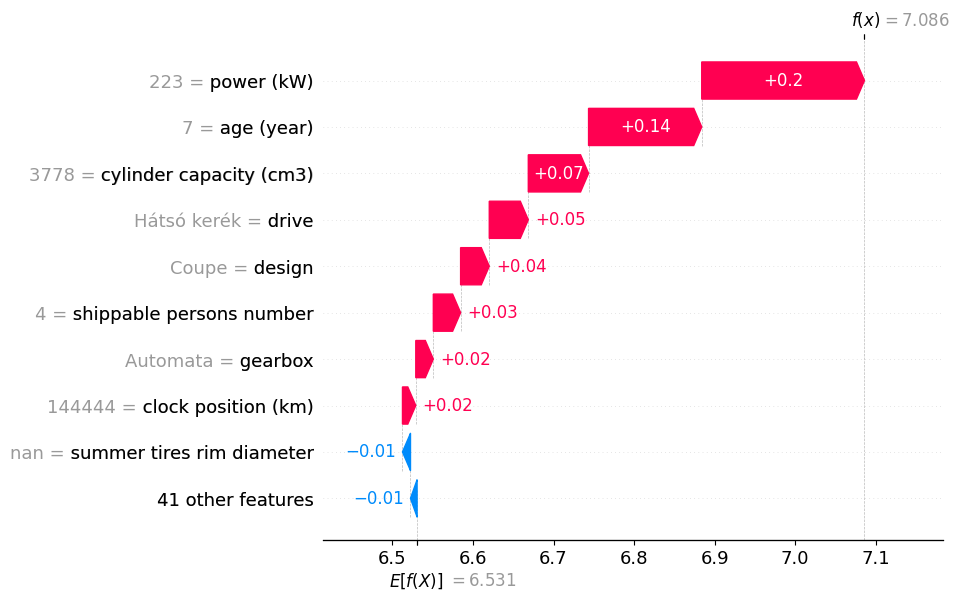

In [154]:
# Get SHAP values for the instance
shap_values = explainer(df[msk][model.feature_names_])

# Create a waterfall plot
plt.figure()
shap.plots.waterfall(shap_values[0])



In [155]:
shap_one = shap_values[0]
new_base = 10**shap_one.base_values
new_values = []
current_value = shap_one.base_values

for val in shap_one.values:
    diff = (10**(current_value+val)) - (10**current_value)
    new_values.append(diff)
    current_value = current_value+val

new_values = np.array(new_values)
new_values /= 375
new_base /= 375

new_values = (new_values/10).astype(int)*10

new_shap_exp = shap._explanation.Explanation(values=new_values, base_values=int(new_base/10)*10, data=shap_one.data, feature_names=model.feature_names_)

In [156]:
new_values

array([3450, 7400,  770, 3880,  460, 2130, 1390,  110, -130, -640, 3290,
       -430, -260, -120, -610,   60, -170,   40,  -90,  140,  510, 2450,
       -590,  430,  220,  160,  -10, -120,  -60,   30, -110,   30,  -30,
        -20,  -70,  240,  -80,  -10,   40,   50,   20, -110,   60, -210,
        -40,    0,   40,  -20,  -20,  -20])

In [157]:
current_value

7.086014487727221

In [158]:
new_base

9049.44337345984

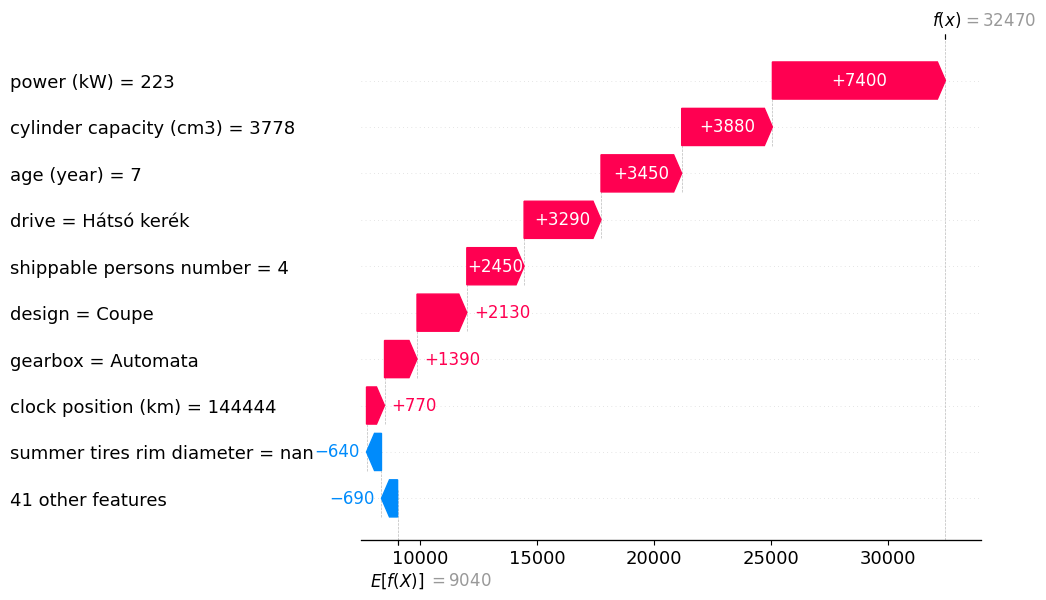

In [161]:

fig, ax = plt.subplots(figsize=(17, 5))
shap.plots.waterfall(new_shap_exp, show=False)
asd = ax.get_yticklabels()
values = np.array(pd.Series([x.get_text() for x in asd[1:10]]).str.split(' = ').to_list())
revers_values = pd.Series(values[:,1]) + " = " +pd.Series(values[:,0])

usd = [None]*10 + [asd[0].get_text()] + list(revers_values)
ax.set_yticklabels(usd, ha='left', x=-0.55)  # Adjust the 'x' value as needed
plt.show()


In [116]:
values

0    [nan, summer tires rim diameter]
1       [144444, clock position (km)]
2                 [Automata, gearbox]
3                     [Coupe, design]
4       [4, shippable persons number]
5                [Hátsó kerék, drive]
6                     [7, age (year)]
7     [3778, cylinder capacity (cm3)]
8                   [223, power (kW)]
dtype: object

In [ ]:
shap.summary_plot(shap_values, X)

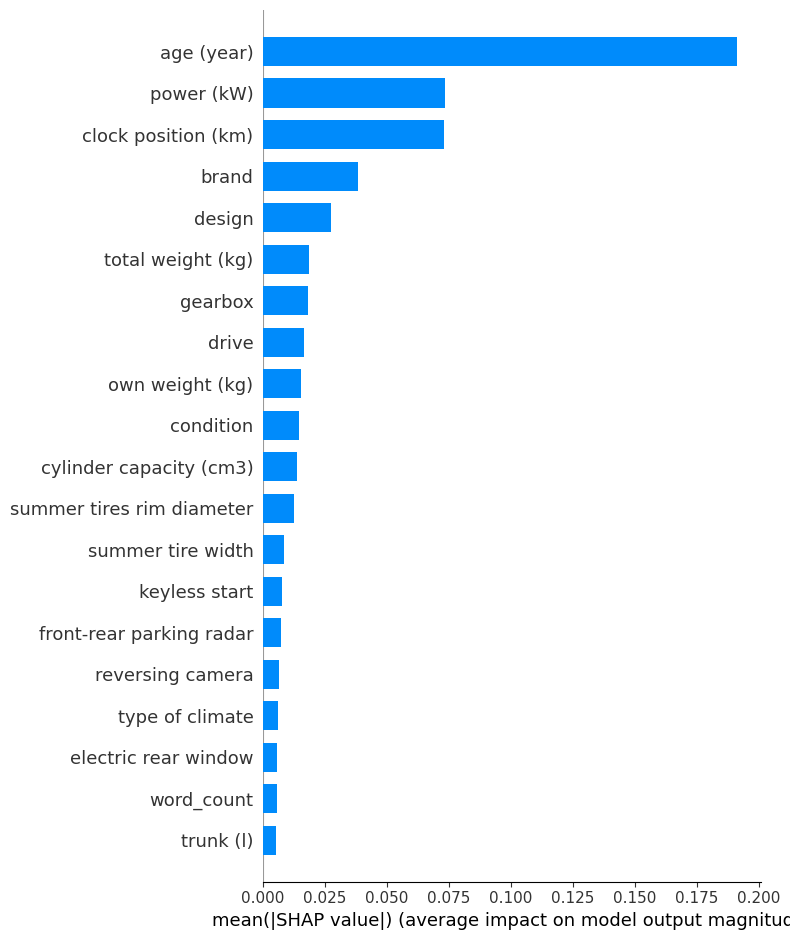

In [554]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [555]:
np.sum(shap_values.mean(axis=1))

0.26132316585507454

In [556]:
np.abs(shap_values)

array([[9.15823769e-02, 1.67953833e-02, 3.34944006e-02, ...,
        1.46677281e-03, 3.32357211e-06, 2.74055176e-04],
       [4.70276721e-02, 7.08688591e-02, 3.38445358e-02, ...,
        1.09765813e-03, 3.17015635e-04, 4.20615721e-04],
       [1.73581907e-01, 3.67088226e-02, 7.30768884e-02, ...,
        9.52949570e-04, 5.50579725e-05, 3.42577960e-04],
       ...,
       [2.83812223e-01, 3.60811680e-01, 1.36771019e-01, ...,
        1.19045386e-04, 1.01451917e-03, 7.16562893e-04],
       [2.62942658e-02, 6.85860359e-03, 7.33876402e-02, ...,
        9.06476249e-04, 9.20456340e-04, 1.52302049e-05],
       [3.04071258e-01, 6.88438191e-02, 9.79598614e-02, ...,
        9.09453850e-04, 1.66083945e-03, 4.45891872e-04]])

In [557]:
mean_shap_values = np.abs(shap_values).mean(axis=0)
sorted_feature_indices = np.argsort(mean_shap_values)[::-1]
sorted_features = np.array(X.columns)[sorted_feature_indices]
sorted_shap_values = mean_shap_values[sorted_feature_indices]

dict(zip(sorted_features, sorted_shap_values))

{'age (year)': 0.19120225968400378,
 'power (kW)': 0.07328311100596763,
 'clock position (km)': 0.07282517610720746,
 'brand': 0.038281782915039864,
 'design': 0.02730268823501725,
 'total weight (kg)': 0.01860334275434345,
 'gearbox': 0.018204363912401204,
 'drive': 0.016489287302645164,
 'own weight (kg)': 0.015369097551791118,
 'condition': 0.014301508878337216,
 'cylinder capacity (cm3)': 0.0135555133212886,
 'summer tires rim diameter': 0.012363475339042819,
 'summer tire width': 0.008478180898202485,
 'keyless start': 0.007453495055174557,
 'front-rear parking radar': 0.007394376855983523,
 'reversing camera': 0.006484820880349145,
 'type of climate': 0.005821004506561127,
 'electric rear window': 0.005675901605205585,
 'word_count': 0.0054224994552929525,
 'trunk (l)': 0.005141474555487809,
 'esp (speed stabilizer)': 0.0045628157766138076,
 'MOT is valid (days)': 0.004084020965635172,
 'fuel': 0.003614843347232635,
 'kept in garage': 0.003602262073467583,
 'lane keeping system':

In [558]:
dict(zip(top_features,np.abs(shap_values).mean(axis=1)))

{'age (year)': 0.007209192358919284,
 'power (kW)': 0.010636883757505138,
 'clock position (km)': 0.010657791168938967,
 'drive': 0.013322290191456925,
 'cylinder capacity (cm3)': 0.01118985544230816,
 'brand': 0.01255119783725061,
 'design': 0.009618332295549188,
 'own weight (kg)': 0.011567901786338083,
 'total weight (kg)': 0.012751887082485744,
 'gearbox': 0.01295845537192295,
 'condition': 0.0134133086205527,
 'summer tire width': 0.013246508682159305,
 'summer tires rim diameter': 0.013351920185982873,
 'reversing camera': 0.014171072595788637,
 'front-rear parking radar': 0.013561793375690523,
 'trunk (l)': 0.01652841140844374,
 'electric rear window': 0.01469003129467519,
 'type of climate': 0.01810264344284666,
 'summer tires aspect ratio': 0.020153997180700576,
 'fuel': 0.02006176099582908,
 'start-stop/engine stop system': 0.020137487328812934,
 'MOT is valid (days)': 0.020411484246632496,
 'word_count': 0.011914031061308871,
 'kept in garage': 0.0068580560058313835,
 'lane 

In [559]:
from analysis_helpers import get_correlations

In [334]:
df['price (EUR)'] = df['price (HUF)'] / 375

In [485]:
import seaborn as sns
import matplotlib.pyplot as plt
    
    
def box_plot_price_by_column(df, x_column_name, y_column_name='price (EUR)', max_category=80):
    # Check if the given column name exists in the DataFrame
    if x_column_name not in df.columns:
        print(f"Column '{x_column_name}' not found in the DataFrame.")
        return

    # Check if the 'price' column exists in the DataFrame
    if y_column_name not in df.columns:
        print(f"Column '{y_column_name}' not found in the DataFrame. Please make sure your DataFrame has a '{y_column_name}' column.")
        return

    # Copy only the necessary columns
    plot_data = df[[x_column_name, y_column_name]].copy()

    # Handle numeric column
    if pd.api.types.is_numeric_dtype(plot_data[x_column_name]):
        unique_values_count = plot_data[x_column_name].nunique()
        if unique_values_count > max_category:
            plot_data[x_column_name] = pd.qcut(plot_data[x_column_name], max_category, precision=0, duplicates='drop')
    
        mean_values = plot_data.groupby(x_column_name)[y_column_name].mean().sort_values(ascending=False)
    # Handle non-numeric columns
    else:
        # Calculate the mean price for each category
        mean_values = plot_data.groupby(x_column_name)[y_column_name].mean().sort_values(ascending=False)
        order = mean_values.index
        plot_data[x_column_name] = plot_data[x_column_name].astype('category').cat.set_categories(order)

    plt.figure(figsize=(13, 3))
    sns.boxplot(x=x_column_name, y=y_column_name, data=plot_data, order=plot_data[x_column_name].cat.categories if plot_data[x_column_name].dtype.name == 'category' else None)
    plt.xticks(rotation=90)  # Rotate the x labels if they are long
    plt.show()
    
    return mean_values


In [560]:
#X.loc[X['own weight (kg)'] > 3000, 'own weight (kg)'] = 3000
#X.loc[X['total weight (kg)'] > 4000, 'total weight (kg)'] = 4000


In [569]:
df_asd = df.copy()

In [570]:
df_asd['design'] = df_asd['design'].replace({'Városi terepjáró (crossover)': 'Crossover',
 'Sedan': 'Sedan',
 'Ferdehátú': 'Hatchback',
 'Other': 'Other',
 'Egyterű auto': 'Minivan',
 'Kombi': 'Wagon',
 'Coupe': 'Coupe'})

In [561]:
X['design'] = X['design'].replace({'Városi terepjáró (crossover)': 'Crossover',
 'Sedan': 'Sedan',
 'Ferdehátú': 'Hatchback',
 'Other': 'Other',
 'Egyterű auto': 'Minivan',
 'Kombi': 'Wagon',
 'Coupe': 'Coupe'})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


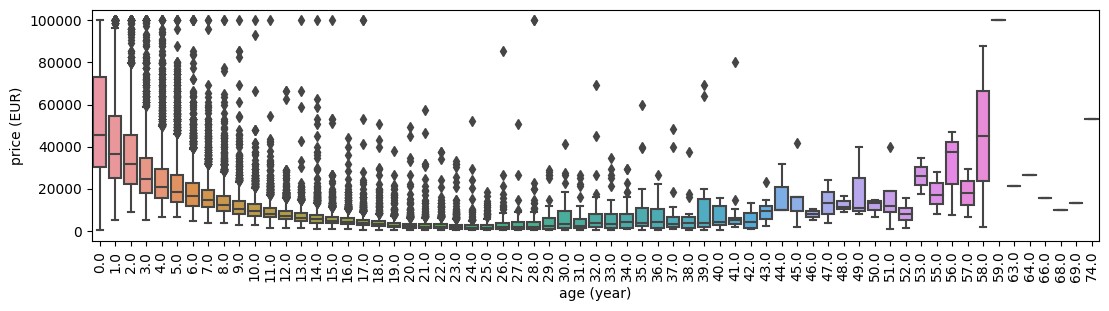

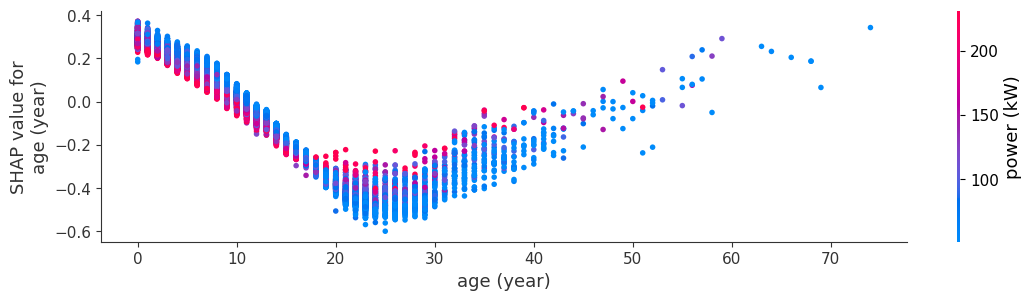

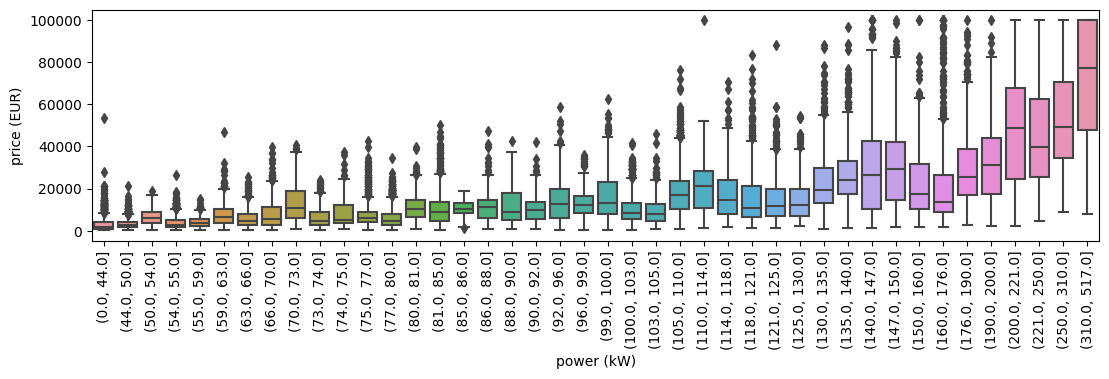

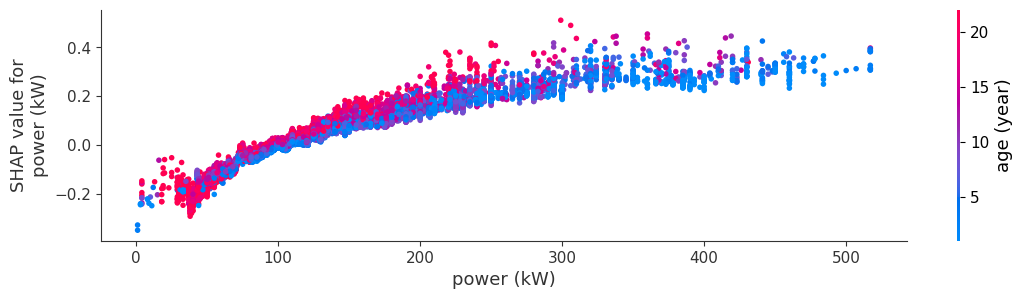

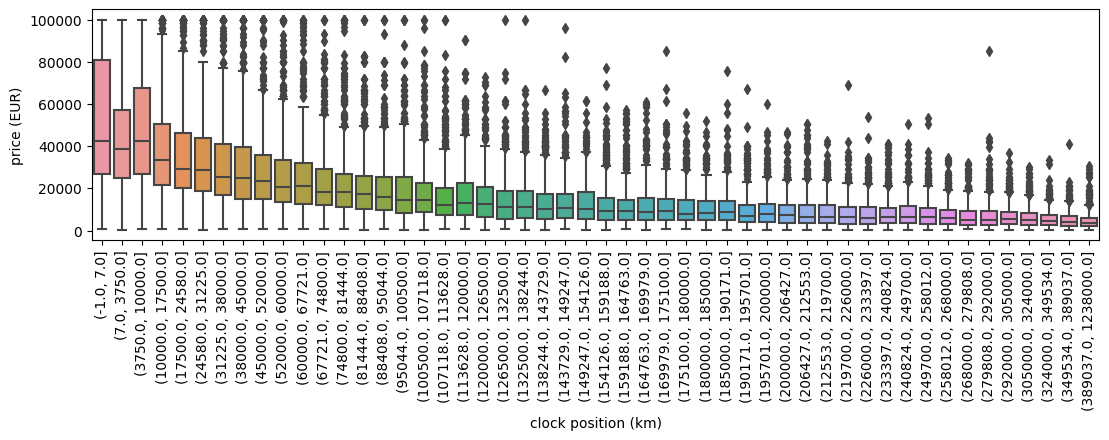

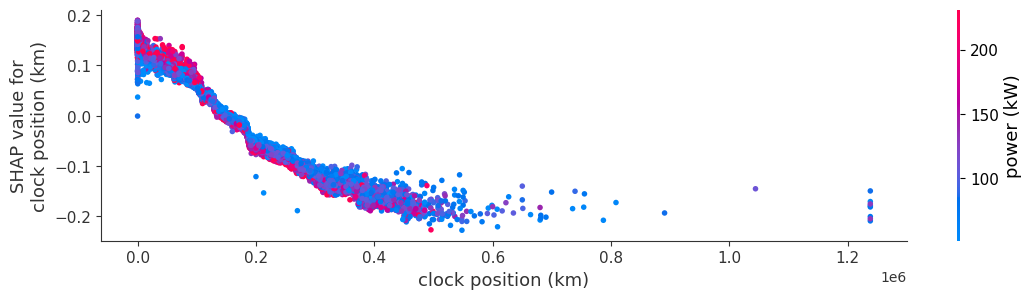

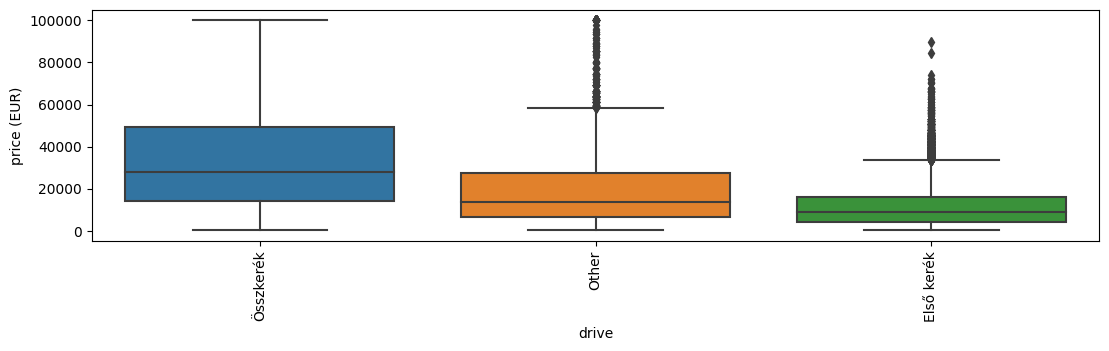

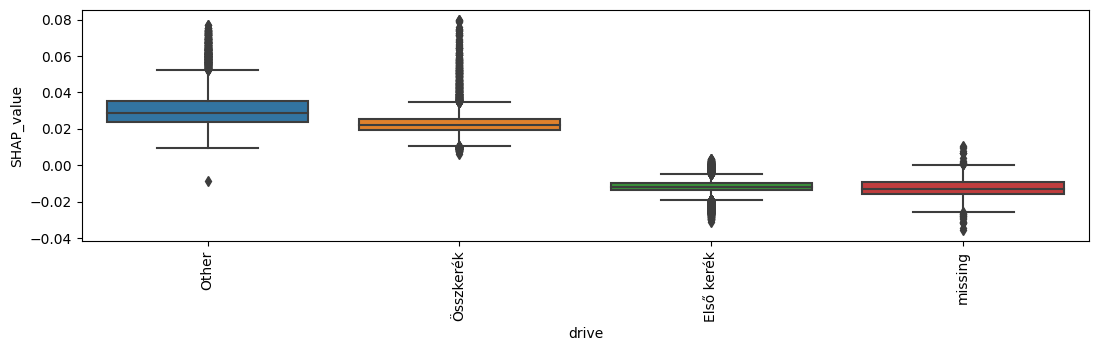

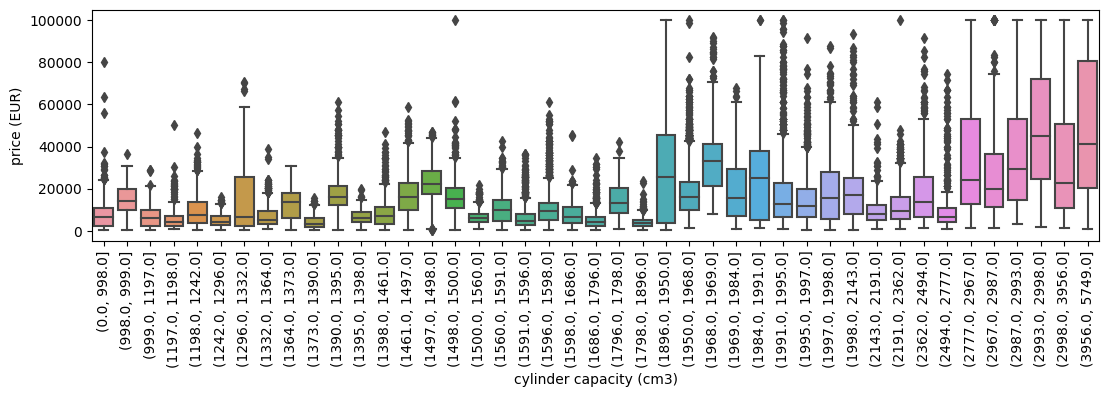

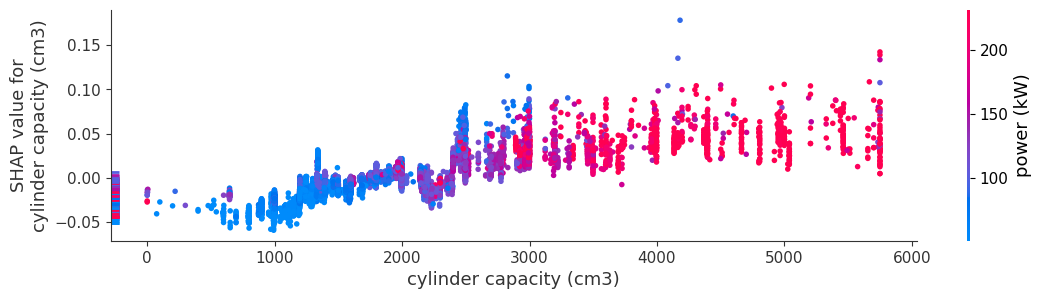

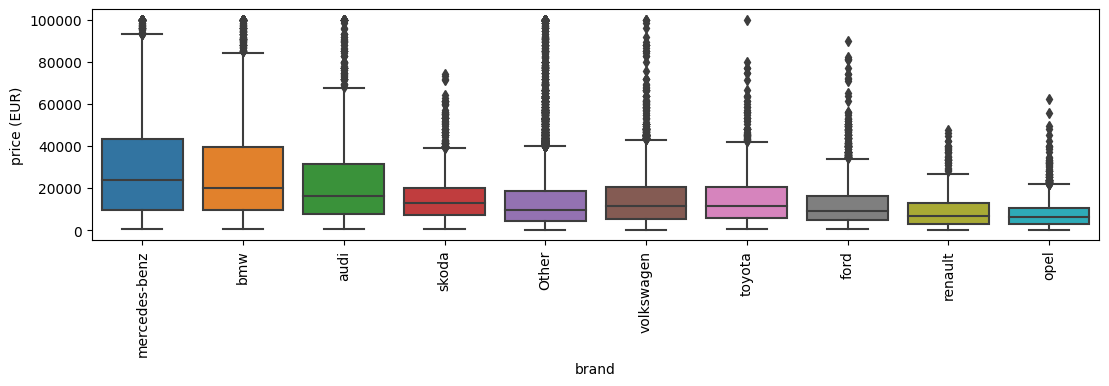

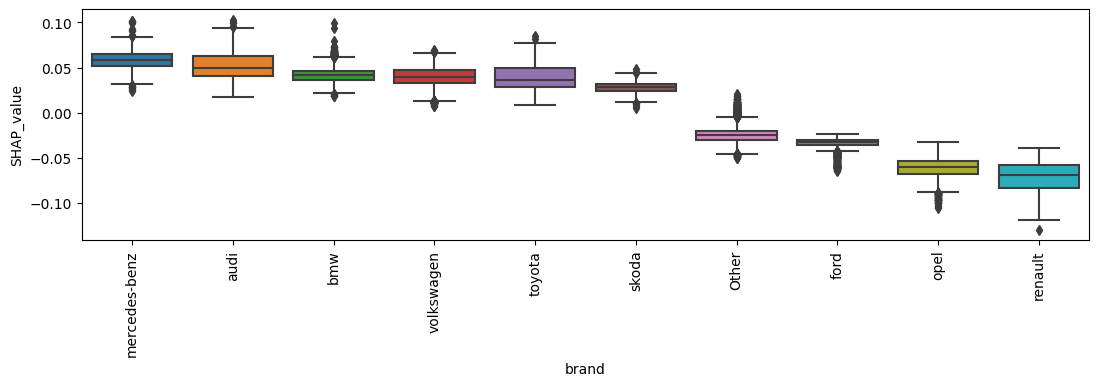

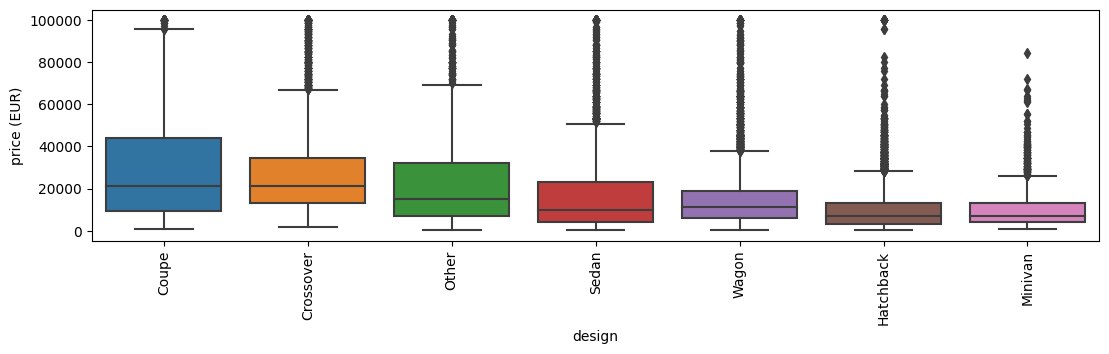

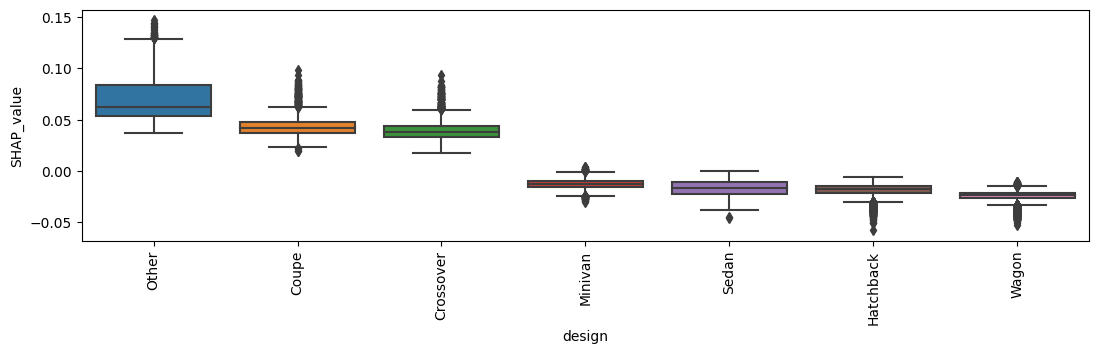

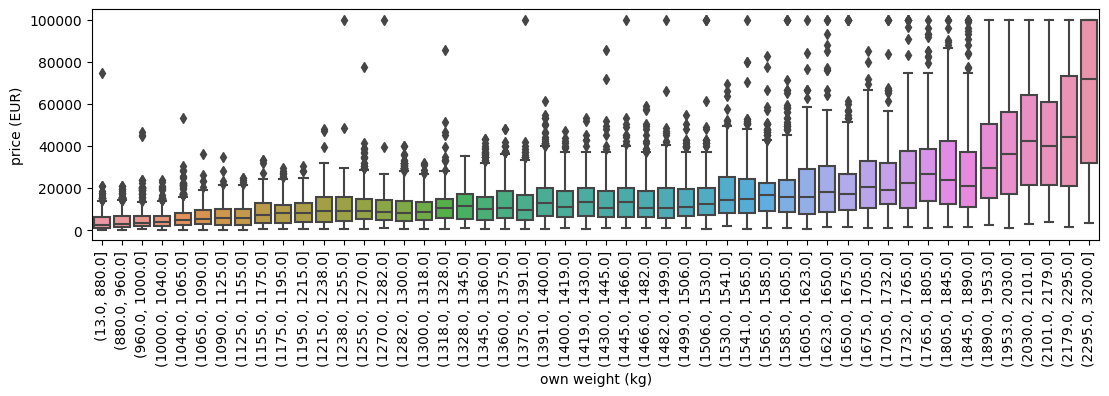

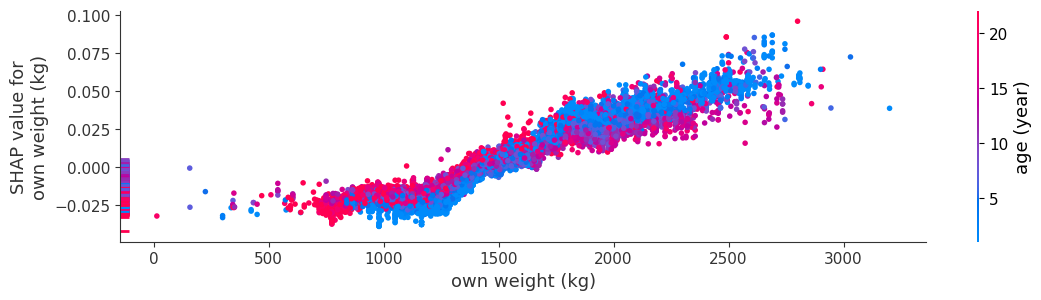

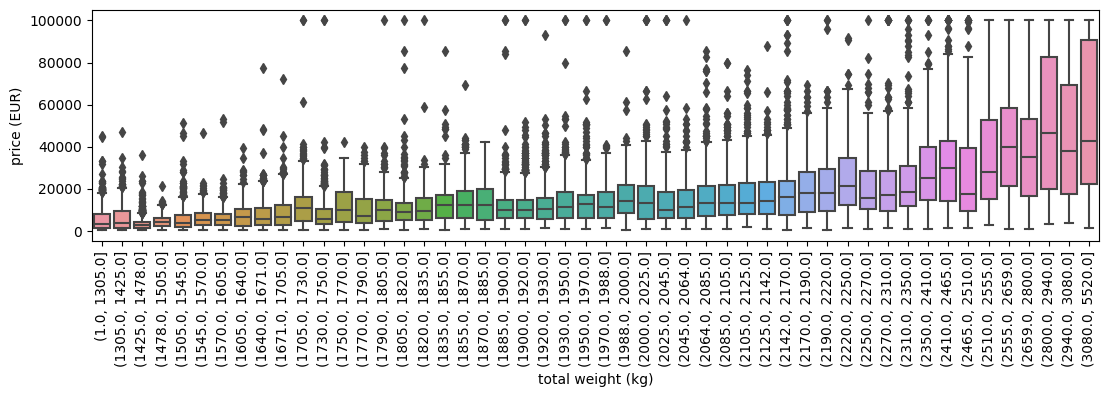

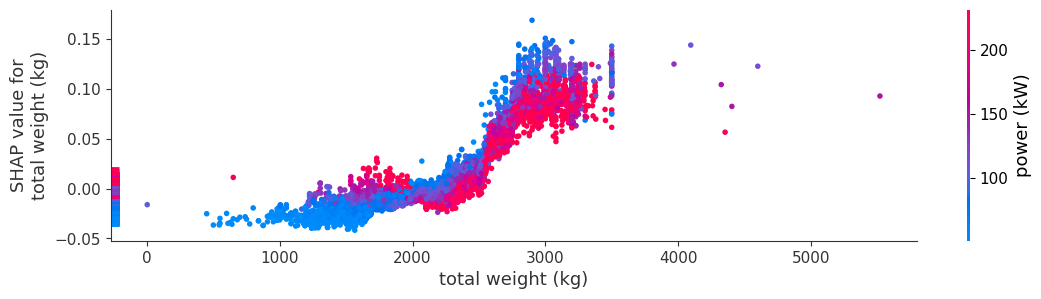

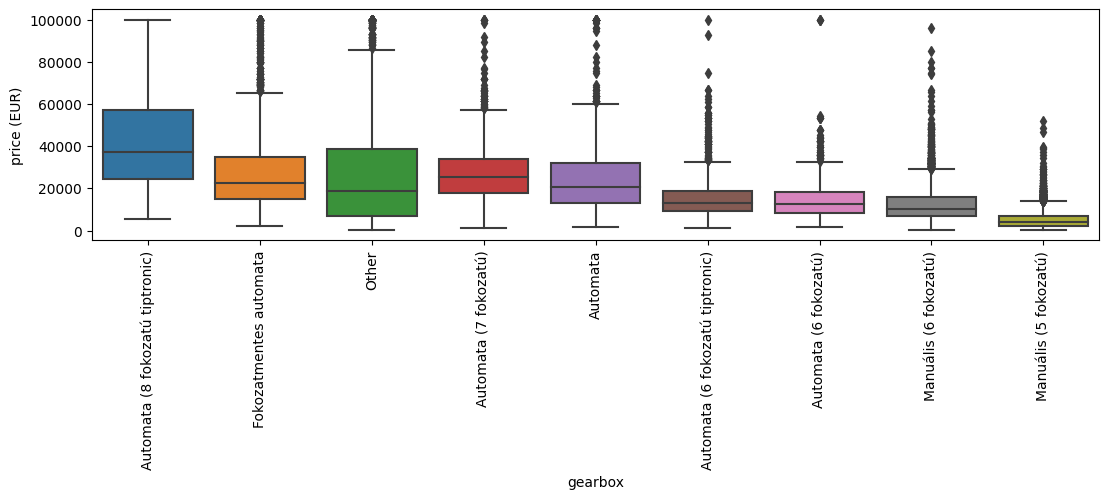

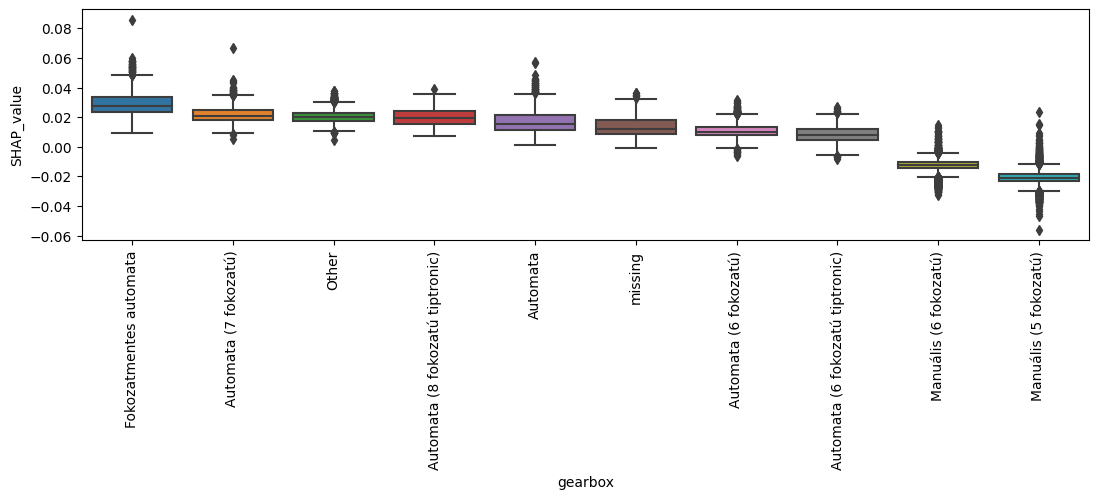

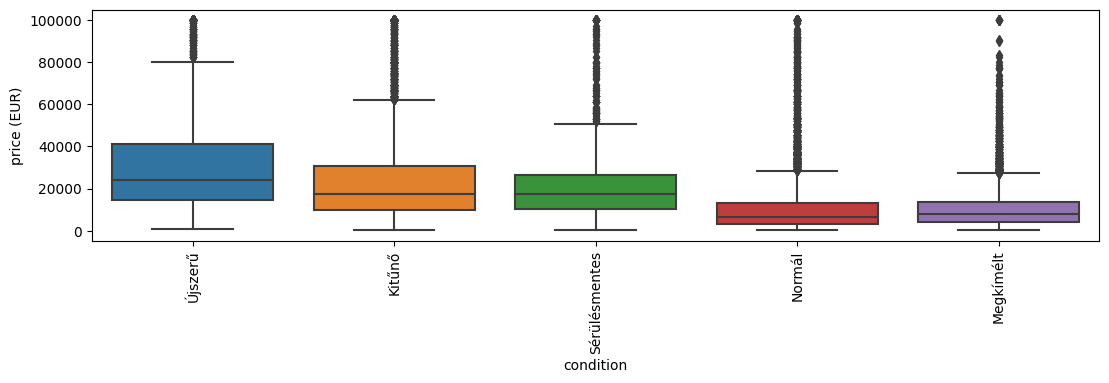

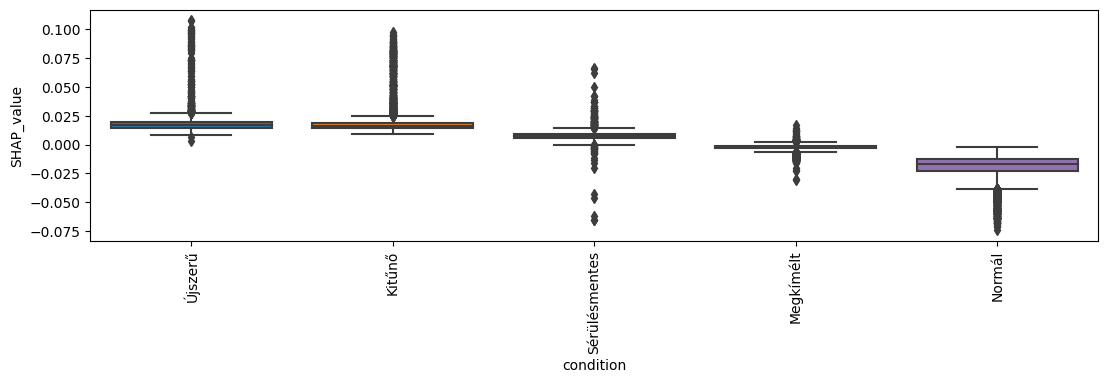

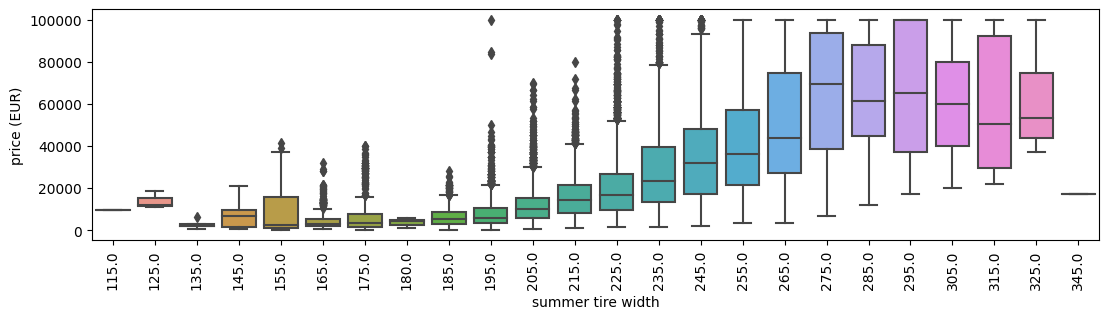

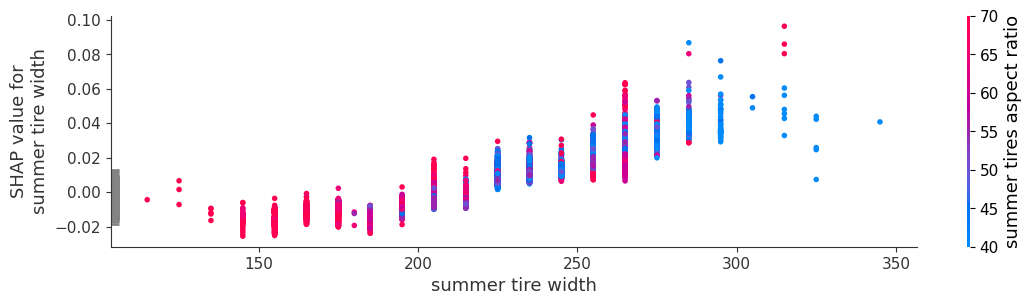

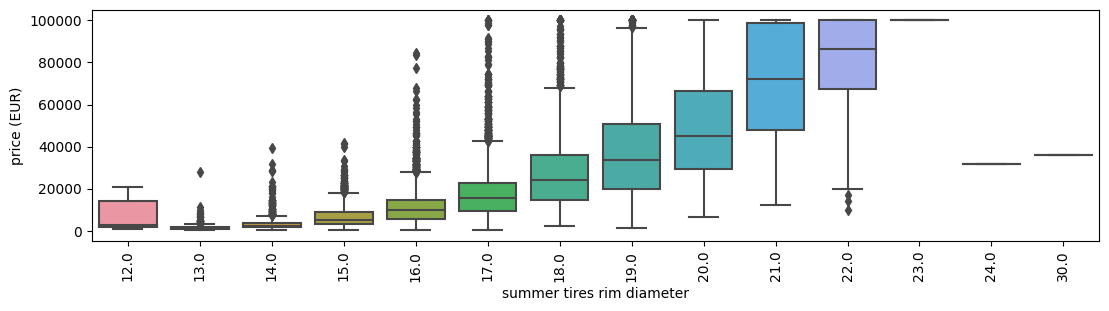

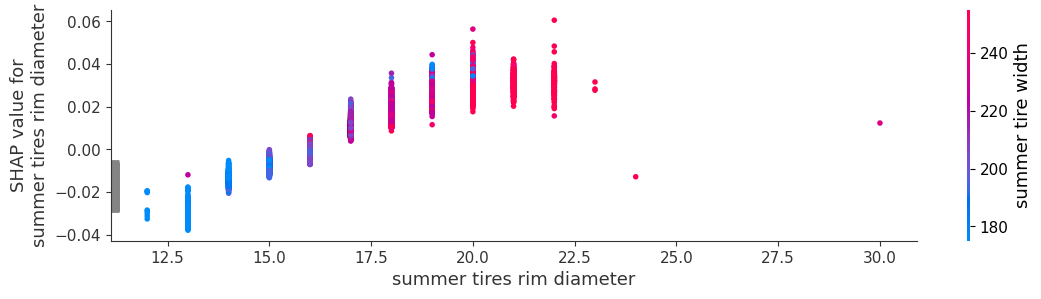

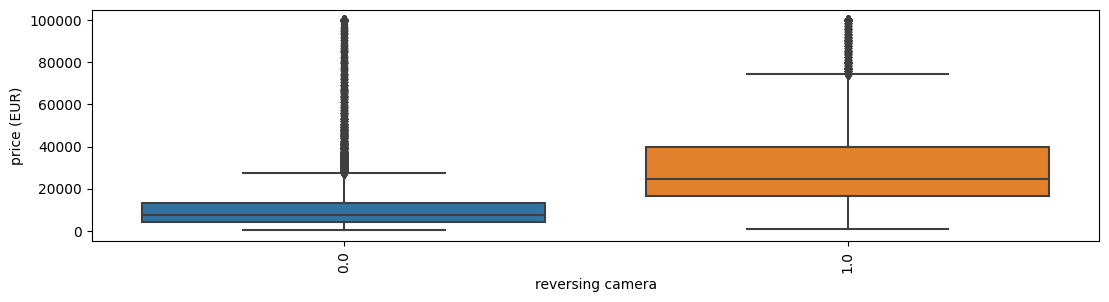

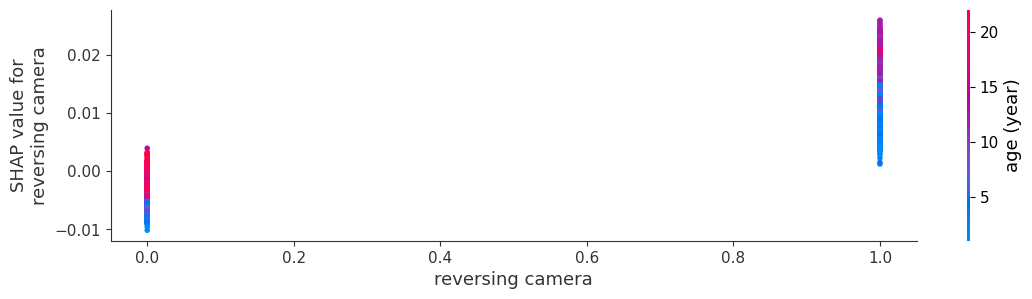

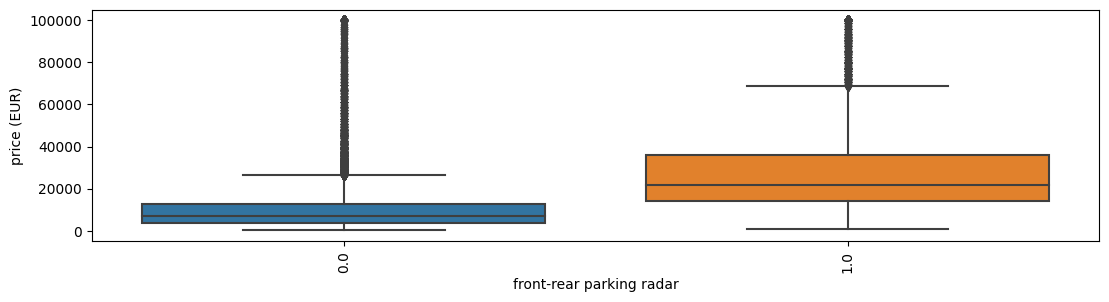

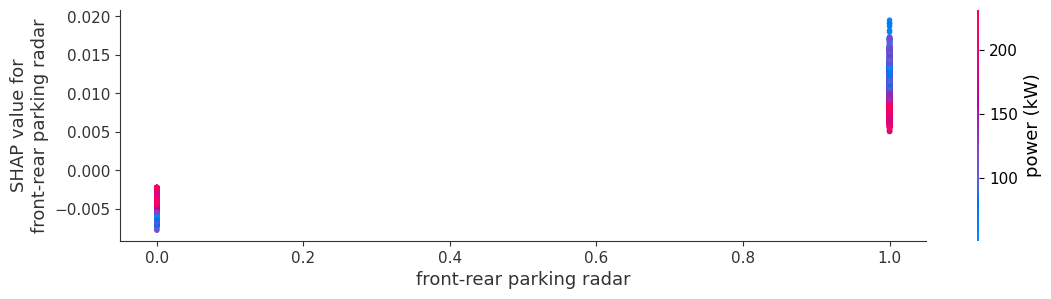

In [571]:
featur_means = {}
for i, col in enumerate(X.columns[:15]):
    if col == 'age (year)':
        mean_values = box_plot_price_by_column(df_asd, col)
    else:
        mean_values = box_plot_price_by_column(df_asd, col, max_category=50)
        
    mean_values = dict(zip(mean_values.keys(),mean_values.astype(int).values))
    
    if df[col].dtype == object:
        df_tmp = X[[col]].copy()
        df_tmp['SHAP_value'] = shap_values[:, i]
        shap_means = box_plot_price_by_column(df_tmp, col, y_column_name='SHAP_value')
        shap_means = dict(zip(shap_means.keys(),shap_means.round(2).values))
        featur_means[col] = { 
            f'average of price for each {col} values': mean_values,
            f'average of SHAP for each {col} values': shap_means,
        }
    else:
        # Create a figure object with the desired size
        fig, ax = plt.subplots(figsize=(13, 3))
        shap.dependence_plot(i, shap_values, X, ax=ax)

In [537]:
#for k in featur_means.keys():
#    featur_means[k] = dict(zip(featur_means[k].keys(),featur_means[k].astype(int).values))
featur_means

{'drive': {'average of price for each drive values': {'Összkerék': 35555,
   'Other': 20361,
   'Első kerék': 11536},
  'average of SHAP for each drive values': {'Other': 0.03,
   'Összkerék': 0.02,
   'Első kerék': -0.01}},
 'brand': {'average of price for each brand values': {'mercedes-benz': 31219,
   'bmw': 28617,
   'audi': 23045,
   'skoda': 15236,
   'Other': 15219,
   'volkswagen': 14986,
   'toyota': 14520,
   'ford': 12432,
   'renault': 8875,
   'opel': 7933},
  'average of SHAP for each brand values': {'mercedes-benz': 0.06,
   'audi': 0.06,
   'volkswagen': 0.04,
   'bmw': 0.04,
   'toyota': 0.04,
   'skoda': 0.03,
   'Other': -0.03,
   'ford': -0.03,
   'opel': -0.06,
   'renault': -0.07}},
 'design': {'average of price for each design values': {'Coupe': 30224,
   'Városi terepjáró (crossover)': 27832,
   'Other': 23243,
   'Sedan': 17511,
   'Kombi': 15731,
   'Ferdehátú': 10149,
   'Egyterű auto': 9862},
  'average of SHAP for each design values': {'Other': 0.07,
   'Co

In [581]:
data = X2.iloc[[np.where(msk)[0][0]]].T
data['shap'] = shap_values[0]
data[data.shap > 0.01]

link                     https://www.hasznaltauto.hu/szemelyauto/cadillac/cts/cadillac_cts_3.6_v6_awd_sport_luxury_automata_cupe_garantalt_16500_km_szervizelt_recaro_bor-19702643  \
age (year)                                                               10                                                                                                          
power (kW)                                                            229.0                                                                                                          
clock position (km)                                                 16500.0                                                                                                          
brand                                                                 Other                                                                                                          
gearbox                                     Automata (6 fokozatú tiptronic)                                                                                                          
condition                                                            Kitűnő                                                                                                          
front-rear parking radar                                              False                                                                                                          
type of climate                                    Digitális kétzónás klíma                                                                                                          
keyless start                                                          True                                                                                                          

link                          shap  
age (year)                0.091582  
power (kW)                0.016795  
clock position (km)       0.033494  
brand                     0.038237  
gearbox                   0.011088  
condition                 0.013094  
front-rear parking radar  0.011242  
type of climate           0.016374  
keyless start             0.012310

In [582]:
expected_value2

6.591852062483691

In [583]:
# Assuming 'model' is your trained CatBoost model
shap_values2 = model2.get_feature_importance(
    data=catboost.Pool(X2, label=np.log10(df_new['price (HUF)']), 
    cat_features=categorical_features2), type="ShapValues"
)
# Note: The last column of shap_values is the expected value
expected_value2 = shap_values2[0,-1]
shap_values2 = shap_values2[:,:-1]

In [590]:
df_select.index[0]

'https://www.hasznaltauto.hu/szemelyauto/hyundai/genesis/hyundai_genesis-19727104'

In [594]:
X2[X2.index == df_select.index[0]]

age (year)  power (kW)  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/hyundai...           7       223.0   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/hyundai...             144444.0   

                                                    drive  \
link                                                        
https://www.hasznaltauto.hu/szemelyauto/hyundai...  Other   

                                                    cylinder capacity (cm3)  \
link                                                                          
https://www.hasznaltauto.hu/szemelyauto/hyundai...                   3778.0   

                                                    brand design  \
link                                                               
https://www.hasznaltauto.hu/szemelyauto/hyundai...  Other  Coupe   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/hyundai...           1515.0   

                                                    total weight (kg)  \
link                                                                    
https://www.hasznaltauto.hu/szemelyauto/hyundai...             1930.0   

                                                     gearbox  ...  \
link                                                          ...   
https://www.hasznaltauto.hu/szemelyauto/hyundai...  Automata  ...   

                                                   tfidf_exchange  \
link                                                                
https://www.hasznaltauto.hu/szemelyauto/hyundai...            0.0   

                                                    tfidf_condition  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/hyundai...              0.0   

                                                    tfidf_car  tfidf_phone  \
link                                                                         
https://www.hasznaltauto.hu/szemelyauto/hyundai...        0.0          0.0   

                                                    tfidf_Hungary  \
link                                                                
https://www.hasznaltauto.hu/szemelyauto/hyundai...            0.0   

                                                    steering gear  \
link                                                                
https://www.hasznaltauto.hu/szemelyauto/hyundai...          False   

                                                    isofix system  \
link                                                                
https://www.hasznaltauto.hu/szemelyauto/hyundai...           True   

                                                   tfidf_climate  tfidf_rear  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/hyundai...           0.0         0.0   

                                                   tfidf_oil  
link                                                          
https://www.hasznaltauto.hu/szemelyauto/hyundai...       0.0  

[1 rows x 50 columns]

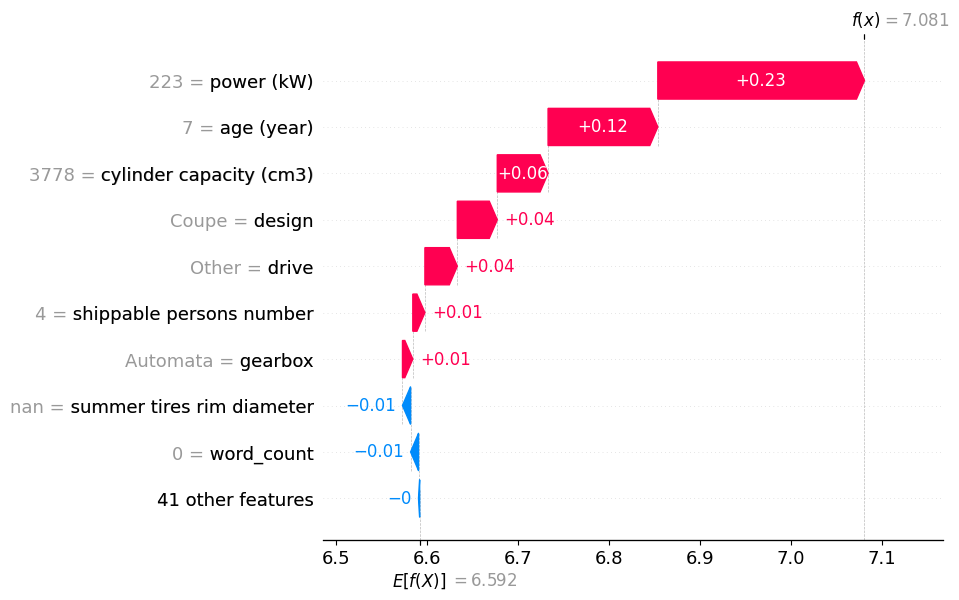

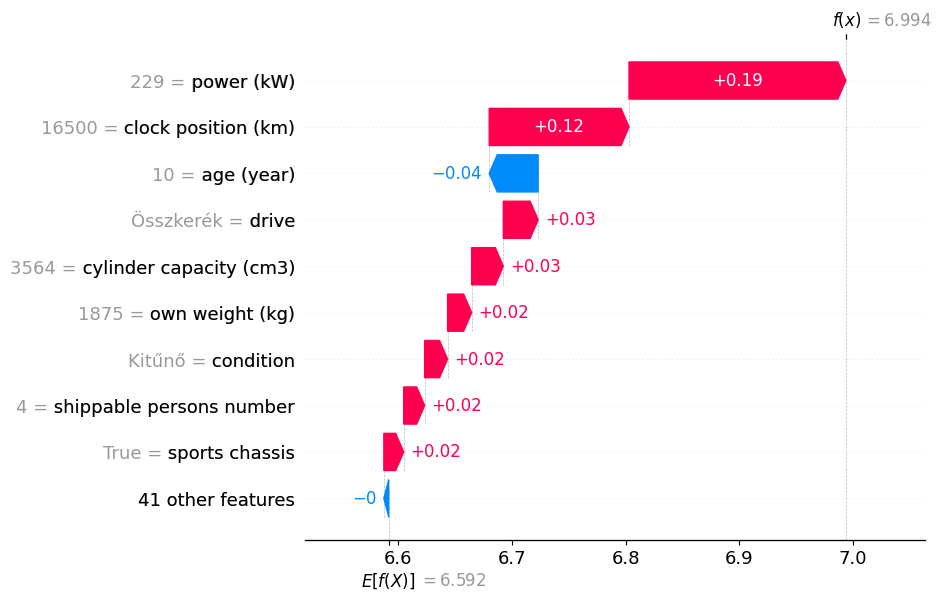

In [598]:
for i in range(2):
    msk = X2.index == df_select.index[i]
    # Assuming explainer is already created
    explainer = shap.TreeExplainer(model2)

    # Assuming shap_values is already computed for a single instance
    shap_values_instance = shap_values2[msk][0]

    # Convert to a shap.Explanation object
    explanation = shap.Explanation(values=shap_values_instance, 
                                    base_values=expected_value2,
                                    data=X2.iloc[np.where(msk)[0][0]], 
                                    feature_names=X2.columns.tolist())

    data = X2.iloc[[np.where(msk)[0][0]]].T
    data['shap'] = shap_values[0]
    data[data.shap.abs() > 0.01].to_csv(f'asd{i}.csv')
    # Plot the waterfall chart
    shap.plots.waterfall(explanation)


In [10]:
explanation

NameError: name 'explanation' is not defined

In [ ]:
def create_buckets(df, column_name, bucket_size):
    df = df.sort_values(column_name)
    
    # Check if the given column name exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the DataFrame.")
        return

    # Check if the column is numeric
    if not pd.api.types.is_numeric_dtype(df[column_name]):
        print(f"Column '{column_name}' must be numeric.")
        return

    # Define the bucketing function
    def bucket_value(value):
        lower_bound = (value // bucket_size) * bucket_size + 1
        upper_bound = lower_bound + bucket_size - 1
        return f"{int(lower_bound)}-{int(upper_bound)}"

    # Apply the bucketing function to the column and create a new column
    df[f'{column_name} buckets'] = df[column_name].apply(bucket_value)

    return df

# Usage example:
# df = create_buckets(df, 'column_name', 10)

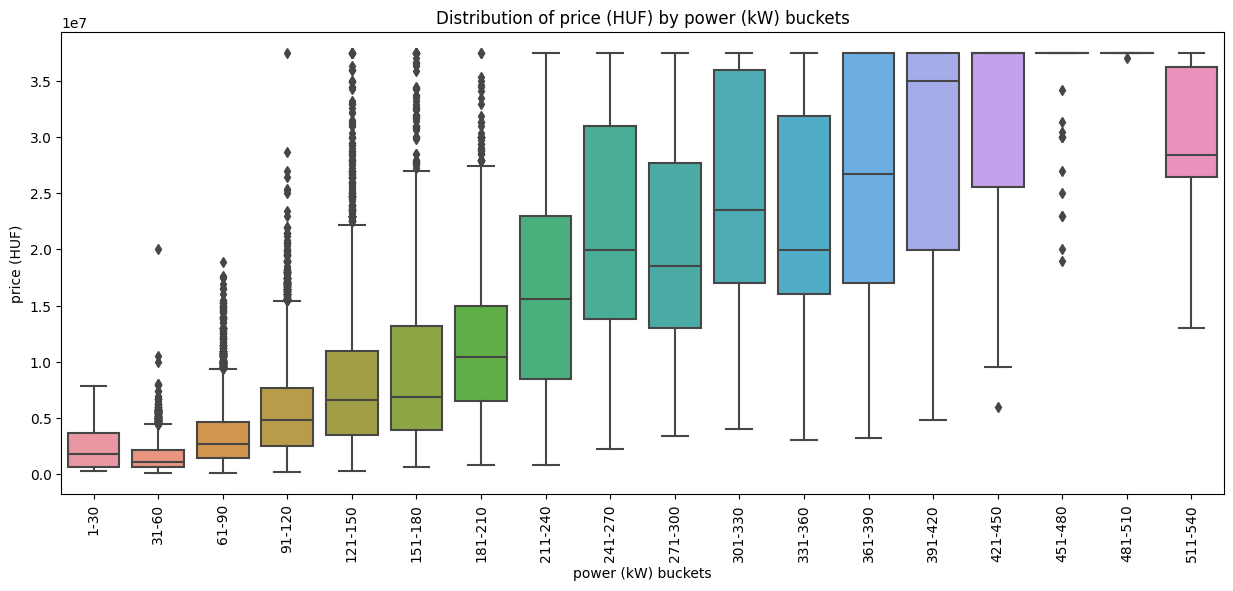

In [80]:
df_tmp_power = df[['price (HUF)', 'power (kW)']].copy()
df_tmp_power = create_buckets(df, 'power (kW)', 30)
plot_price_by_column(df_tmp_power, 'power (kW) buckets')

In [74]:
df[df['power (kW)'] == 1]

price (HUF) condition  \
link                                                                        
https://www.hasznaltauto.hu/szemelyauto/ac/egye...    2000000.0   Újszerű   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...    1999000.0   Újszerű   

                                                   design  financing  \
link                                                                   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...  Other      100.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...  Other      100.0   

                                                    clock position (km)  \
link                                                                      
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              15000.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              15200.0   

                                                    shippable persons number  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/ac/egye...                       2.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...                       2.0   

                                                    number of doors  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              2.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              NaN   

                                                          color  \
link                                                              
https://www.hasznaltauto.hu/szemelyauto/ac/egye...       szürke   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...  sötétszürke   

                                                    own weight (kg)  \
link                                                                  
https://www.hasznaltauto.hu/szemelyauto/ac/egye...            300.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...            300.0   

                                                    total weight (kg)  ...  \
link                                                                   ...   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...              550.0  ...   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...              500.0  ...   

                                                    tfidf_buying tfidf_buys  \
link                                                                          
https://www.hasznaltauto.hu/szemelyauto/ac/egye...           0.0        0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...           0.0        0.0   

                                                   tfidf_end  tfidf_condition  \
link                                                                            
https://www.hasznaltauto.hu/szemelyauto/ac/egye...       0.0              0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...       0.0              0.0   

                                                    tfidf_adjustable  \
link                                                                   
https://www.hasznaltauto.hu/szemelyauto/ac/egye...               0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...               0.0   

                                                   tfidf_price tfidf_inquire  \
link                                                                           
https://www.hasznaltauto.hu/szemelyauto/ac/egye...         0.0           0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...         0.0           0.0   

                                                    tfidf_administration  \
link                                                                       
https://www.hasznaltauto.hu/szemelyauto/ac/egye...                   0.0   
https://www.hasznaltauto.hu/szemelyauto/egyeb/e...                   0.0   

                                                    tfidf_seat  price log  
link                                           

In [58]:
useful_features = df_feature_importance[df_feature_importance.importance > 0.1]['feature'].values
len(useful_features)

40

In [59]:
df_corr = get_correlations(df_transformed[features])

In [43]:
df_tmp = df.drop(columns=['price (HUF)', 'price log'])
#df_tmp = df_tmp.fillna(df_tmp.median(numeric_only=True))
#df_tmp = df_tmp.fillna('missing')
#df_tmp = df_tmp.replace('', np.nan)


In [28]:
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

def pair_wise_modeling(df):
    results = []
    columns = df.columns
    
    all_cat_features = df.select_dtypes(include=['object']).columns
    for i in range(len(columns)):
        print(columns[i])
        for j in range(len(columns)):
            if columns[i] == columns[j]:
                continue
            
            # Not predict for nan
            msk = ~df[columns[j]].isna()
            X = df.loc[msk,[columns[i]]]
            y = df.loc[msk, columns[j]]
            
            if columns[i] in all_cat_features:
                cat_features = [columns[i]]
                X = X.fillna('missing')
            else:
                cat_features = None
                
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Check if the target is numerical or categorical
            if y.dtype == 'object':
                model = CatBoostClassifier(iterations=100, depth=4, learning_rate=0.1, 
                                           loss_function='MultiClass', early_stopping_rounds=10, 
                                           cat_features=cat_features)
                model.fit(X_train, y_train, verbose=False, eval_set=(X_test, y_test))
                pred = model.predict(X_test)
                score = f1_score(y_test, pred, average='macro')
                model_type = 'classification'
            else:
                model = CatBoostRegressor(iterations=100, depth=4, learning_rate=0.1, 
                                          loss_function='RMSE', early_stopping_rounds=10,
                                          cat_features=cat_features)
                model.fit(X_train, y_train, verbose=False, eval_set=(X_test, y_test))
                pred = model.predict(X_test)
                score = r2_score(y_test, pred)
                model_type = 'regression'
                
            results.append([columns[i], columns[j], score, model_type])
    return pd.DataFrame(results, columns=['variable1', 'variable2', 'score', 'model_type'])

In [30]:
base_score = {}
for col in categorical_features:
    msk = ~df[col].isna()
    y = df.loc[msk, col]
    max_value = y.value_counts().keys()[0]
    min_socre = f1_score(y, [max_value]*len(y), average='macro')
    base_score[col] = min_socre
    
base_score

{'condition': 0.09614703172615813,
 'design': 0.06317756362566826,
 'color': 0.04311988501363996,
 'type of climate': 0.11421540884372154,
 'fuel': 0.1631798282539148,
 'drive': 0.2690837484072744,
 'gearbox': 0.0507281546742567,
 'brand': 0.0545799886941775,
 'city': 0.43099052292298073}

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def custom_dependency_plot(explainer, shap_values, X, feature_name, interaction_feature, color_order=None):
    # Select the SHAP values for the specified feature
    feature_shap_values = shap_values[:, X.columns.get_loc(feature_name)]

    # Create a DataFrame containing the feature values, SHAP values, and interaction feature values
    plot_data = pd.DataFrame({
        feature_name: X[feature_name],
        "SHAP Value": feature_shap_values,
        interaction_feature: X[interaction_feature]
    })

    custom_palette = sns.color_palette("viridis", n_colors=plot_data[interaction_feature].nunique())
    if not color_order:
        color_map = {category: color for category, color in zip(plot_data[interaction_feature].unique(), custom_palette)}
    else:
        color_map = {category: color for category, color in zip(color_order, custom_palette)}
    
    # Create a custom plot using Seaborn
    plt.figure(figsize=(13, 3))
    sns.scatterplot(
        data=plot_data, 
        x=feature_name, 
        y="SHAP Value", 
        hue=interaction_feature, 
        palette=color_map,
        #alpha=,
    )
    plt.title(f'Dependency Plot for {feature_name} with {interaction_feature}')
    plt.show()

# Example usage
custom_dependency_plot(
    explainer, shap_values, X, 
    feature_name="age (year)", interaction_feature="condition", 
    color_order=['Normál', 'Megkímélt', 'Sérülésmentes', 'Kitűnő', 'Újszerű']
)


In [183]:
"""
# Use the function
result_df = pair_wise_modeling(df_tmp)

result_df.reset_index(drop=True)
result_df.to_parquet('feature_realations_catboost.parquet')
"""
result_df = pd.read_parquet('feature_realations_catboost.parquet')
result_df.head()#"""

for k, v in base_score.items():
    result_df.loc[result_df.variable2 == k, 'score'] = (result_df.loc[result_df.variable2 == k, 'score'] - v) / (1-v)

In [184]:
df_corr_back = df_corr.copy()
df_corr_back.rename(columns={'variable1':'variable2', 'variable2':'variable1'}, inplace=True)


In [185]:
df_feature_relation = pd.merge(pd.concat([df_corr, df_corr_back]), result_df, on = ['variable1', 'variable2'], how='right')
df_feature_relation = pd.merge(df_feature_relation, df_feature_importance, left_on='variable1', right_on='feature', how='left')

df_tmp_realtion = df_feature_relation.copy()
df_tmp_realtion.rename(columns={'variable1': 'variable2', 'variable2': 'variable1'}, inplace=True)
df_feature_relation = pd.merge(
    df_feature_relation, 
    df_tmp_realtion[['variable1', 'variable2', 'score']],
    on = ['variable1', 'variable2']
)

varaible_pairs = df_feature_relation[['variable1', 'variable2']].values
varaible_pairs.sort(axis=1)
is_dublicated = pd.DataFrame(varaible_pairs).duplicated()

df_feature_relation = df_feature_relation[~is_dublicated]
df_feature_relation['score'] = df_feature_relation[['score_x', 'score_y']].max(axis=1)
df_feature_relation

variable1                 variable2  correlation   score_x  \
0                 condition                    design          NaN  0.033704   
1                 condition                 financing          NaN  0.015718   
2                 condition       clock position (km)          NaN  0.168422   
3                 condition  shippable persons number          NaN  0.000511   
4                 condition           number of doors          NaN  0.002744   
...                     ...                       ...          ...       ...   
85846           tfidf_price      tfidf_administration    -0.034500  0.008638   
85847           tfidf_price                tfidf_seat    -0.027704  0.011913   
86140         tfidf_inquire      tfidf_administration     0.007354  0.013925   
86141         tfidf_inquire                tfidf_seat    -0.044974  0.008267   
86435  tfidf_administration                tfidf_seat    -0.026553  0.024829   

           model_type               feature  importance  cumsum_importance  \
0      classification             condition    1.532662          82.567134   
1          regression             condition    1.532662          82.567134   
2          regression             condition    1.532662          82.567134   
3          regression             condition    1.532662          82.567134   
4          regression             condition    1.532662          82.567134   
...               ...                   ...         ...                ...   
85846      regression           tfidf_price    0.139846          91.343864   
85847      regression           tfidf_price    0.139846          91.343864   
86140      regression         tfidf_inquire    0.044659          97.038113   
86141      regression         tfidf_inquire    0.044659          97.038113   
86435      regression  tfidf_administration    0.031974          98.184395   

        score_y     score  
0      0.070598  0.070598  
1      0.062171  0.062171  
2      0.161611  0.168422  
3      0.036273  0.036273  
4      0.026454  0.026454  
...         ...       ...  
85846  0.006688  0.008638  
85847  0.001493  0.011913  
86140  0.009991  0.013925  
86141  0.005215  0.008267  
86435  0.004152  0.024829  

[43365 rows x 10 columns]

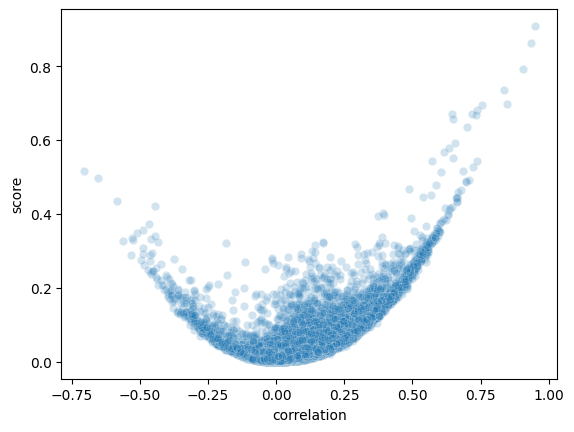

In [186]:
sns.scatterplot(data=df_feature_relation, x='correlation', y='score', alpha=0.2)
plt.show()

array([[<Axes: title={'center': 'correlation'}>]], dtype=object)

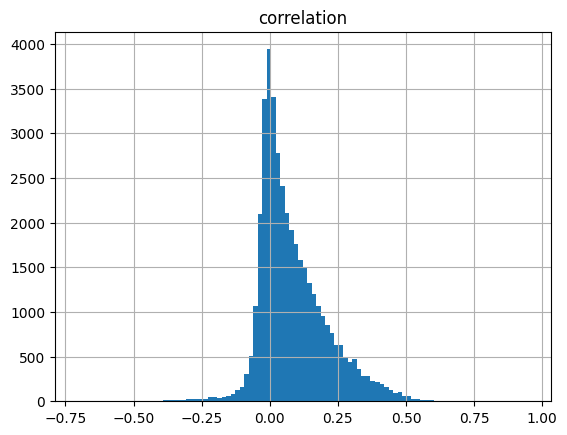

In [187]:
df_corr.hist('correlation', bins=100)

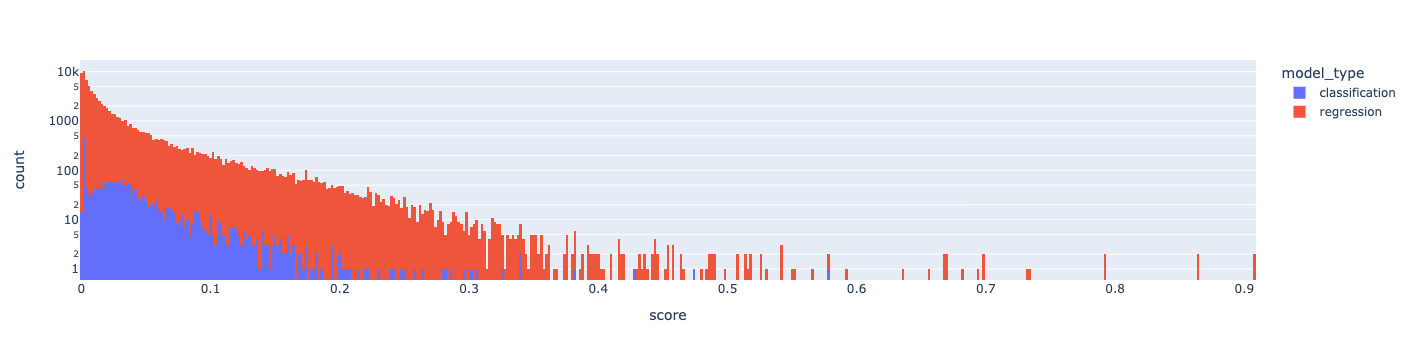

In [188]:
import plotly.express as px
px.histogram(result_df[result_df.score > 0], x='score', color='model_type', log_y=True,)


In [206]:
df_feature_relation2 = df_feature_relation.copy()
df_feature_relation2.sort_values('score', ascending=False, inplace=True)
df_feature_relation2 = df_feature_relation2[
    (df_feature_relation2.importance > 0.02) &
    (df_feature_relation2.score > 0.35)
]
df_feature_relation2

variable1  \
2065                        own weight (kg)   
5311                      summer tire width   
28922  electric seat adjustment driver side   
3540                cylinder capacity (cm3)   
2075                        own weight (kg)   
2369                      total weight (kg)   
3839                             power (kW)   
60823                 tfidf_making an offer   
3841                             power (kW)   
2070                        own weight (kg)   
2069                        own weight (kg)   
2364                      total weight (kg)   
3245                                   fuel   
2363                      total weight (kg)   
2077                        own weight (kg)   
23910                         keyless start   
3545                cylinder capacity (cm3)   
5605              summer tires aspect ratio   
2371                      total weight (kg)   
5310                      summer tire width   
7080                          driver airbag   
5062                          buy_from_shop   
1084                    clock position (km)   
3541                cylinder capacity (cm3)   
3547                cylinder capacity (cm3)   
8261                 predictable government   
1180               shippable persons number   
60800                 tfidf_making an offer   
28941  electric seat adjustment driver side   
4429                                gearbox   
3835                             power (kW)   
4427                                gearbox   
29799                   lane keeping system   
298                                  design   
3842                             power (kW)   
8267                 predictable government   
2071                        own weight (kg)   
61977                          tfidf_counts   
2072                        own weight (kg)   
62326                       tfidf_insurance   
29803                   lane keeping system   
16526                           rain sensor   
3248                                   fuel   
2961                        type of climate   
3432                                   fuel   
3932                             power (kW)   
3427                                   fuel   
2973                        type of climate   
3840                             power (kW)   
8567                            side airbag   
2365                      total weight (kg)   
69937                              tfidf_ad   
8271                 predictable government   
3836                             power (kW)   
15635                bluetooth speakerphone   
8262                 predictable government   

                                     variable2  correlation   score_x  \
2065                         total weight (kg)     0.948875  0.908940   
5311                 summer tires rim diameter     0.835657  0.734747   
28922  electric seat adjustment passenger side     0.845365  0.697473   
3540                                power (kW)     0.754134  0.667283   
2075                         summer tire width     0.735593  0.681444   
2369                         summer tire width     0.718652  0.670994   
3839                         summer tire width     0.645856  0.670862   
60823                       tfidf_it counts as     0.733864  0.483389   
3841                 summer tires rim diameter     0.648683  0.656194   
2070                                power (kW)     0.698883  0.518625   
2069                   cylinder capacity (cm3)     0.657622  0.507932   
2364                                power (kW)     0.632808  0.458717   
3245                   cylinder capacity (cm3)          NaN  0.071776   
2363                   cylinder capacity (cm3)     0.616370  0.454903   
2077                 summer tires rim diameter     0.648753  0.552179   
23910                     keyless entry system     0.738247  0.542570   
3545                         summer tire width     0.571350  0.542108   
5605                 summer tires rim di

In [207]:
import matplotlib

In [211]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from pyvis.network import Network

def create_interactive_graph_with_communities(df, df_feature_importance, relation_name='score', size_column='importance'):
    # Create a graph from the dataframe
    G_nx = nx.from_pandas_edgelist(df, 'variable1', 'variable2', edge_attr=relation_name)

    # Compute the best partition
    partition = community_louvain.best_partition(G_nx, weight='score', resolution=1)

    # Count number of unique communities
    num_communities = len(set(partition.values()))

    # Create a PyVis graph for visualization
    G_pyvis = Network(notebook=True)

    colormap = plt.get_cmap('viridis')

    # Add nodes with color and title based on their community
    for node, community in partition.items():
        color = matplotlib.colors.rgb2hex(colormap(community / num_communities))
        size = df_feature_importance[df_feature_importance['feature'] == node][size_column].values[0]  # get the size from the size_column
        G_pyvis.add_node(node, color=color, value=np.log(size+1), title=f"Importance: {round(size,2)}%")  # add value attribute to set node size and title for info

    # Add edges only within communities and with title
    for edge in G_nx.edges(data=True):
        if partition[edge[0]] == partition[edge[1]]:  # If nodes belong to the same community
            weight = round(edge[2][relation_name], 3)
            G_pyvis.add_edge(edge[0], edge[1], title=f"Predictive score: {weight}")

    # Transform partition into a list of communities
    communities = list(set(partition.values()))
    community_lists = [[node for node, community in partition.items() if community == c] for c in communities]

    return G_pyvis, community_lists




In [ ]:
predictabel_government
design
lane keeping system
memory driver seat
speaker count
side airbag

In [212]:
net = Network(notebook=True, cdn_resources='in_line')

In [213]:
G, communities = create_interactive_graph_with_communities(df_feature_relation2, df_feature_importance, size_column='importance')
G.show_buttons(filter_=['physics'])
G.show("graph.html")

graph.html


In [175]:
flattened_list = [item for sublist in communities for item in sublist]

single_communities = list(set(df_feature_importance['feature']) - set(flattened_list))
total_communities = communities.copy()
for x in single_communities:
    total_communities.append([x])
    
#total_communities

In [199]:
def get_most_important_features(communities, df_feature_importance, min_sum_ratio=0.8):
    most_important_features = []

    for community in communities:
        # Filter the features from this community
        community_feature_importances = df_feature_importance[df_feature_importance['feature'].isin(community)]

        # Sort the features in descending order of importance
        community_feature_importances = community_feature_importances.sort_values(by='importance', ascending=False)

        # Calculate the cumulative importance
        community_feature_importances['cumulative_importance'] = community_feature_importances['importance'].cumsum()

        # Select the most important features, up to 95% of the total importance
        sum_importance = community_feature_importances['importance'].sum()
        min_importance_sum = max(sum_importance * min_sum_ratio, community_feature_importances['cumulative_importance'].min())
        selected_features = community_feature_importances[
            community_feature_importances['cumulative_importance'] <= min_importance_sum
        ]['feature'].tolist()

        most_important_features.extend(selected_features)

    return most_important_features

# Use this function to get the most important features
important_features = get_most_important_features(communities, df_feature_importance)


In [200]:
max_features = 20
df_feature_importance_top_community=df_feature_importance.loc[
    df_feature_importance.feature.isin(important_features), :
].head(max_features)
df_feature_importance_top = df_feature_importance.head(max_features)

In [201]:
def selected_features_train(features):
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    categorical_features_selected = [x for x in categorical_features if x in features]
    model = regression_train(X_train_selected, X_test_selected, y_train, y_test, categorical_features_selected)
    
    test_predictions = model.predict(X_test_selected)
    return metrics.r2_score(y_test, test_predictions)

In [202]:
r2_results = []
for i in range(1, len(df_feature_importance_top)+1):
    features = df_feature_importance_top.head(i)['feature'].values
    r2 = selected_features_train(features)
    r2_results.append(r2)

0:	learn: 0.3574437	test: 0.3573802	best: 0.3573802 (0)	total: 6.37ms	remaining: 31.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1823002584
bestIteration = 419

Shrink model to first 420 iterations.
0:	learn: 0.3559339	test: 0.3556614	best: 0.3556614 (0)	total: 4.15ms	remaining: 20.8s
1000:	learn: 0.1017989	test: 0.1055630	best: 0.1055630 (1000)	total: 3.31s	remaining: 13.2s


KeyboardInterrupt: 

In [203]:
features_community = df_feature_importance_top_community['feature'].values
r2_community = selected_features_train(features_community)

features_top = df_feature_importance_top['feature'].values
r2_top = selected_features_train(features_top)

0:	learn: 0.3560131	test: 0.3557676	best: 0.3557676 (0)	total: 17.9ms	remaining: 1m 29s
1000:	learn: 0.0703310	test: 0.0787208	best: 0.0787208 (1000)	total: 10.3s	remaining: 41.1s
2000:	learn: 0.0659965	test: 0.0776318	best: 0.0776318 (2000)	total: 20.1s	remaining: 30.1s
3000:	learn: 0.0635448	test: 0.0770676	best: 0.0770665 (2996)	total: 29.9s	remaining: 19.9s
4000:	learn: 0.0616569	test: 0.0767594	best: 0.0767594 (4000)	total: 39.9s	remaining: 9.96s
4999:	learn: 0.0603372	test: 0.0765440	best: 0.0765429 (4985)	total: 49.9s	remaining: 0us

bestTest = 0.07654291787
bestIteration = 4985

Shrink model to first 4986 iterations.
0:	learn: 0.3560795	test: 0.3557966	best: 0.3557966 (0)	total: 10.3ms	remaining: 51.3s
1000:	learn: 0.0594962	test: 0.0678868	best: 0.0678868 (1000)	total: 11.9s	remaining: 47.7s
2000:	learn: 0.0541335	test: 0.0660241	best: 0.0660230 (1998)	total: 23.8s	remaining: 35.7s
3000:	learn: 0.0514358	test: 0.0653499	best: 0.0653499 (3000)	total: 35.7s	remaining: 23.8s
4000

In [179]:
r2_top_community

0.9358542048904865

In [180]:
r2_top

0.9544455487330908

In [204]:
set(features_community) - set(features_top)

{'automatically dimming interior mirror',
 'buy_from_shop',
 'curtain airbag',
 'electrically folding exterior mirrors',
 'electronic parking brake',
 'keyless start',
 'tfidf_electronic',
 'tfidf_window',
 'word_count'}

In [205]:
set(features_top) - set(features_community)

{'MOT is valid (days)',
 'clock position (km)',
 'condition',
 'summer tire width',
 'summer tires aspect ratio',
 'summer tires rim diameter',
 'total weight (kg)',
 'trunk (l)',
 'type of climate'}